# Lag-Llama: Towards Foundation Models for Probabilistic Time Series Forecasting

![lag-llama-architecture](https://raw.githubusercontent.com/time-series-foundation-models/lag-llama/main/images/lagllama.webp)

Lag-Llama is the <b>first open-source foundation model for time series forecasting</b>!

[[Tweet Thread](https://twitter.com/arjunashok37/status/1755261111233114165)] [[Model Weights](https://huggingface.co/time-series-foundation-models/Lag-Llama)] [[Colab Demo on Zero-Shot Forecasting](https://colab.research.google.com/drive/1XxrLW9VGPlZDw3efTvUi0hQimgJOwQG6?usp=sharing)] [[GitHub](https://github.com/time-series-foundation-models/lag-llama)] [[Paper](https://arxiv.org/abs/2310.08278)]

💫 This Colab Demo shows you how to use the pretrained Lag-Llama model to get zero-shot predictions on time series, with the ability to load time series of different formats.


# Update 17/Feb

This Colab demo is an update to the [previous Colab demo](https://colab.research.google.com/drive/13HHKYL_HflHBKxDWycXgIUAHSeHRR5eo?usp=sharing). In this notebook, we show **how one can load time series in different formats**.

If your time series is of a format that is not described here, please create [an issue in our GitHub repository](https://github.com/time-series-foundation-models/lag-llama/issues), and we can discuss how to load it.

-------


**Please make a copy of this notebook if you would like to save your changes (File -> Save a copy in ...)**

# Prepare the repository

We first clone and install the required packages from the [GitHub repository](https://github.com/time-series-foundation-models/lag-llama/) that has the Lag-Llama architecture.



In [1]:
!git clone https://github.com/time-series-foundation-models/lag-llama/

Cloning into 'lag-llama'...
remote: Enumerating objects: 124, done.
remote: Counting objects: 100% (69/69), done.
remote: Compressing objects: 100% (48/48), done.
remote: Total 124 (delta 38), reused 42 (delta 21), pack-reused 55
Receiving objects: 100% (124/124), 191.92 KiB | 2.67 MiB/s, done.
Resolving deltas: 100% (48/48), done.


In [2]:
cd /content/lag-llama

/content/lag-llama


In [3]:
!pip install -r requirements.txt --quiet # this could take some time # ignore the errors displayed by colab

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 45.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 51.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 55.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.4/345.4 kB 36.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 71.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 778.1/778.1 kB 58.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.4/195.4 kB 20.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.5/258.5 kB 22.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.7/67.7 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.4/840.4 kB 38.8 MB/s eta 0:00:00
ERROR: pip's dependency res

We then download our pretrained model weights from [HuggingFace](https://huggingface.co/time-series-foundation-models/Lag-Llama) 🤗

In [4]:
!huggingface-cli download time-series-foundation-models/Lag-Llama lag-llama.ckpt --local-dir /content/lag-llama

Consider using `hf_transfer` for faster downloads. This solution comes with some limitations. See https://huggingface.co/docs/huggingface_hub/hf_transfer for more details.
downloading https://huggingface.co/time-series-foundation-models/Lag-Llama/resolve/main/lag-llama.ckpt to /root/.cache/huggingface/hub/tmplgb_nz1r
lag-llama.ckpt: 100% 29.5M/29.5M [00:00<00:00, 142MB/s]
/content/lag-llama/lag-llama.ckpt


We import the required packages and the lag llama estimator object which we can use to make predictions.

In [4]:
from itertools import islice

from matplotlib import pyplot as plt
import matplotlib.dates as mdates

import torch
from gluonts.evaluation import make_evaluation_predictions, Evaluator
from gluonts.dataset.repository.datasets import get_dataset

from gluonts.dataset.pandas import PandasDataset
import pandas as pd

from lag_llama.gluon.estimator import LagLlamaEstimator

ModuleNotFoundError: No module named 'gluonts'

# Lag-Llama prediction function

We create a function for Lag-Llama inference that we can reuse for all different types of dataset below. This function returns the predictions for the given prediction horizon. The forecast will be of shape (`num_samples`, `prediction_length`), where `num_samples` is the number of samples sampled from the predicted probability distribution for each timestep.


In [1]:
def get_lag_llama_predictions(dataset, prediction_length, num_samples=100):
    ckpt = torch.load("lag-llama.ckpt", map_location=torch.device('cuda:0')) # Uses GPU since in this Colab we use a GPU.
    estimator_args = ckpt["hyper_parameters"]["model_kwargs"]

    estimator = LagLlamaEstimator(
        ckpt_path="lag-llama.ckpt",
        prediction_length=prediction_length,
        context_length=32, # Should not be changed; this is what the released Lag-Llama model was trained with

        # estimator args
        input_size=estimator_args["input_size"],
        n_layer=estimator_args["n_layer"],
        n_embd_per_head=estimator_args["n_embd_per_head"],
        n_head=estimator_args["n_head"],
        scaling=estimator_args["scaling"],
        time_feat=estimator_args["time_feat"],

        batch_size=1,
        num_parallel_samples=100
    )

    lightning_module = estimator.create_lightning_module()
    transformation = estimator.create_transformation()
    predictor = estimator.create_predictor(transformation, lightning_module)

    forecast_it, ts_it = make_evaluation_predictions(
        dataset=dataset,
        predictor=predictor,
        num_samples=num_samples
    )
    forecasts = list(forecast_it)
    tss = list(ts_it)

    return forecasts, tss

# Loading datasets of different types

We expand upon how one can support loading data stored in different formats. This part of the demo uses the tutorial by the authors of GluonTS at https://ts.gluon.ai/stable/tutorials/data_manipulation/pandasdataframes.html. We thank the authors of GluonTS for putting together such a detailed tutorial.

## Important Points to Note

1. The prediction function provided in this notebook performs a prediction autoregressively for the last `prediction_length` steps in the dataset passed.

For the time being, if you would like to perform prediction, please include in the CSV/dataframe the timestamps you want to perform prediction for (with a dummy value), and set the prediction length to the required horizon.

2. Please keep in mind that Lag-Llama needs a minimum context of `32` timestamps before the prediction timestamp starts. Beyond the `32` timestamps, Lag-Llama can use a context of upto `1092` more timestamps in history for the lags - this part is optional but you will find that as you give more context upto `(32+) 1092` timestamps, Lag-Llama's performance will improve.

The context length passed below should not be changed and kept at 32 nevertheless. Lag-Llama will automatically use context beyond 32 for the lags, if available.


## 1. Loading data from a long CSV

We are given multiple time series stacked on top of each other in a dataframe with an `item_id` column that distinguishes different series.

The `item_id` is required only when your dataset has multiple series.

When your CSV has just one series, `item_id` is not required. In this case, when creating the `PandasDataset`,  `item_id` need not be passed.

In [ ]:
import numpy as np

In [3]:
train = pd.read_csv('train_llama.csv', index_col=0)

train.index = pd.to_datetime(train.index)

NameError: name 'pd' is not defined

In [243]:
data = train.resample('h').mean().astype(np.float32).dropna()

dates = pd.date_range(data.index.min(), end=data.index.max(), freq="1H")[:len(data)]

data.index = dates

In [254]:
dataset = PandasDataset(dict(data))

backtest_dataset = dataset
prediction_length = 12 # Define your prediction length. We use 24 here since the data is of hourly frequency
num_samples = 100 # number of samples sampled from the probability distribution for each timestep

### Get predictions

We perform zero-shot inference.

In [255]:
forecasts, tss = get_lag_llama_predictions(backtest_dataset, prediction_length, num_samples)

AttributeError: 'LagLlamaEstimator' object has no attribute 'children'

`forecasts` is a list of size `num_series` where `num_series` is the number of time series in your dataset. The samples can be accessed with the `.samples` object from each forecast.

`tss` is the ground truth time series, which is useful to visualize when plotting. You can ignore it otherwise.

In [247]:
len(forecasts)

28

In [248]:
forecasts[0].samples.shape

(100, 48)

We plot the forecasts of our model on this dataset, along with the ground truth.

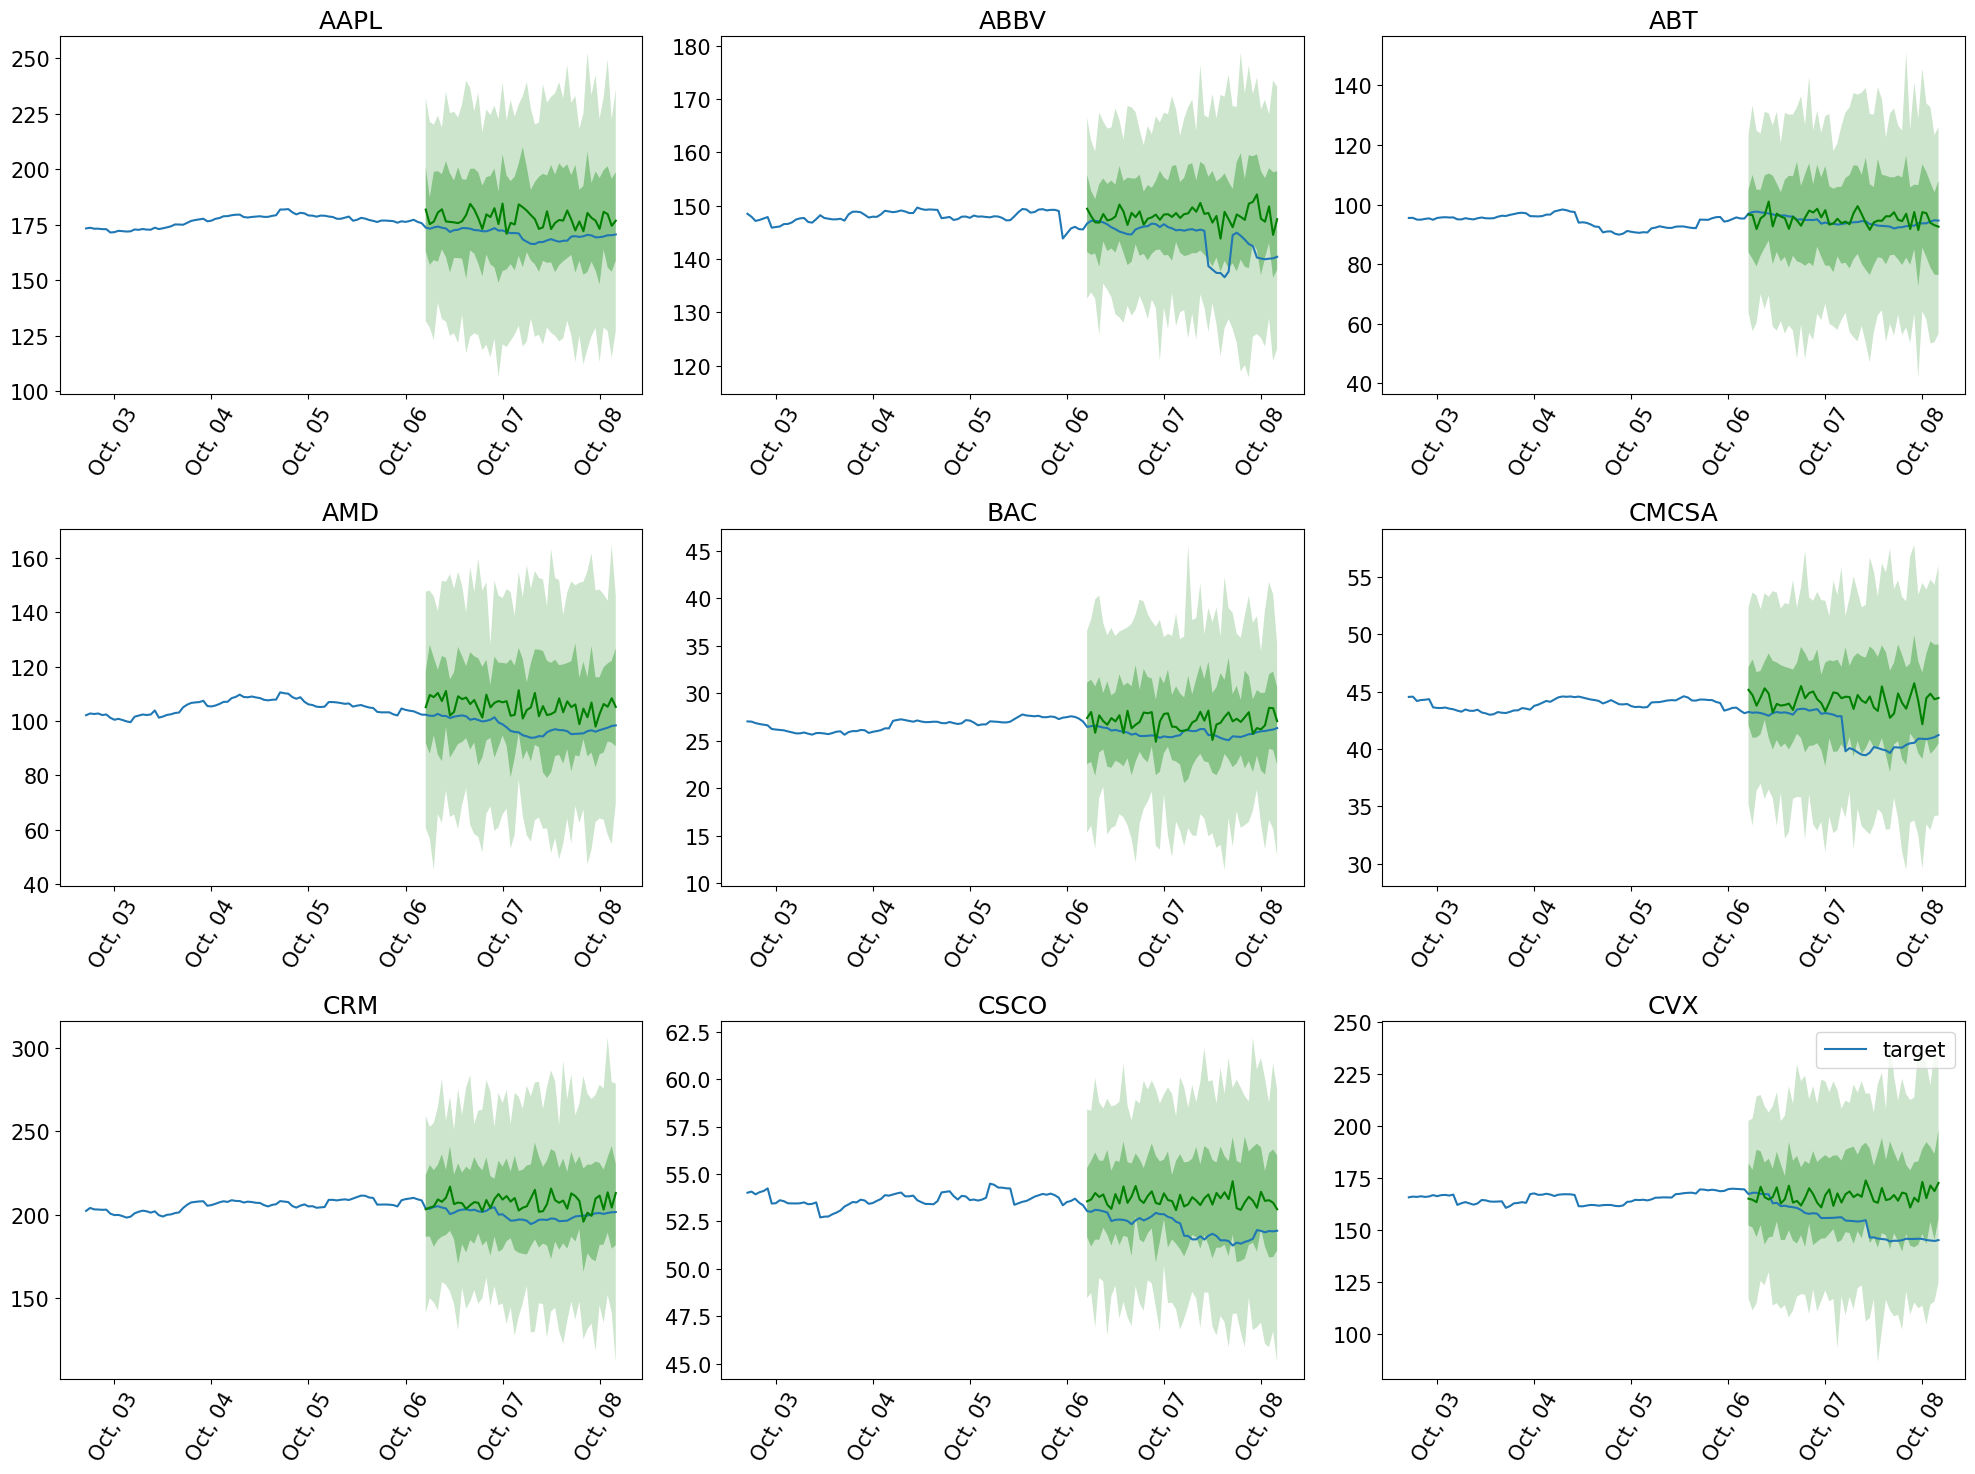

In [249]:
plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter('%b, %d')
plt.rcParams.update({'font.size': 15})

# Iterate through the first 9 series, and plot the predicted samples
for idx, (forecast, ts) in islice(enumerate(zip(forecasts, tss)), 9):
    ax = plt.subplot(3, 3, idx+1)

    plt.plot(ts[-4 * prediction_length:].to_timestamp(), label="target", )
    forecast.plot( color='g')
    plt.xticks(rotation=60)
    ax.xaxis.set_major_formatter(date_formater)
    ax.set_title(forecast.item_id)

plt.gcf().tight_layout()
plt.legend()
plt.show()

## 2. Loading data with missing values

In case the timestamp column is not evenly spaced and monotonically increasing we get an error when using PandasDataset. Here we show how to fill in the gaps that are missing.

To demonstrate this, let’s first remove some random rows from the long dataset.

In [170]:
import pandas as pd
import numpy as np
from gluonts.dataset.pandas import PandasDataset

url = (
    "https://gist.githubusercontent.com/rsnirwan/a8b424085c9f44ef2598da74ce43e7a3"
    "/raw/b6fdef21fe1f654787fa0493846c546b7f9c4df2/ts_long.csv"
)
df = pd.read_csv(url, index_col=0, parse_dates=True)
remove_ind = np.random.choice(np.arange(df.shape[0]), size=100, replace=False)
mask = [False if i in remove_ind else True for i in range(df.shape[0])]
df_missing_val = df.loc[mask, :]  # dataframe with 100 rows removed from df
df

,target,item_id
2021-01-01 00:00:00,-1.3378,A
2021-01-01 01:00:00,-1.6111,A
2021-01-01 02:00:00,-1.9259,A
2021-01-01 03:00:00,-1.9184,A
2021-01-01 04:00:00,-1.9168,A
...,...,...
2021-01-10 19:00:00,1.2349,J
2021-01-10 20:00:00,1.1525,J
2021-01-10 21:00:00,1.1485,J
2021-01-10 22:00:00,1.3248,J


Now, we group by the `item_id` and reindex each of the grouped dataframes. Reindexing, as it is done below, will add new rows with `NaN` values where the data is missing.
If required, the user can then use the `fillna()` method on each dataframe to fill in desired value.

However, Lag-Llama supports datasets with `NaN` rows and the imputation is completely optional.


In [ ]:
# Get the max end date
max_end = max(df.groupby("item_id").apply(lambda _df: _df.index[-1]))
dfs_dict = {}
for item_id, gdf in df_missing_val.groupby("item_id"):
    # Get the full (regular) date range
    new_index = pd.date_range(gdf.index[0], end=max_end, freq="1H")
    # Reindex the dataframe
    dfs_dict[item_id] = gdf.reindex(new_index).drop("item_id", axis=1)
    # Conver the columns to float32 for lag-llama
    for col in dfs_dict[item_id]:
        # Check if column is not of string type
        if dfs_dict[item_id][col].dtype != 'object' and pd.api.types.is_string_dtype(dfs_dict[item_id][col]) == False:
            dfs_dict[item_id][col] = dfs_dict[item_id][col].astype('float32')

# Create a PandasDataset
ds = PandasDataset(dfs_dict, target="target")

In [ ]:
backtest_dataset = ds
prediction_length = 24  # Define your prediction length. We use 24 here since the data is of hourly frequency
num_samples = 100 # number of samples sampled from the probability distribution for each timestep

In [176]:
# max_end = data.index.max()

# dfs_dict = {}
# for item_id, gdf in df_missing_val.groupby("item_id"):
#     # print(gdf)
#     new_index = pd.date_range(gdf.index[0], end=max_end, freq="1H")

#     # dfs_dict[item_id] = gdf.reindex(new_index).drop("item_id", axis=1)


# # Create a PandasDataset
# ds = PandasDataset(dfs_dict, target="target")

### Get predictions

We perform zero-shot inference.

In [ ]:
forecasts, tss = get_lag_llama_predictions(backtest_dataset, prediction_length, num_samples)

`forecasts` is a list of size `num_series` where `num_series` is the number of time series in your dataset. The samples can be accessed with the `.samples` object from each forecast.

`tss` is the ground truth time series, which is useful to visualize when plotting. You can ignore it otherwise.

In [ ]:
len(forecasts)

10

In [ ]:
forecasts[0].samples.shape

(100, 24)

We plot the forecasts of our model on this dataset.

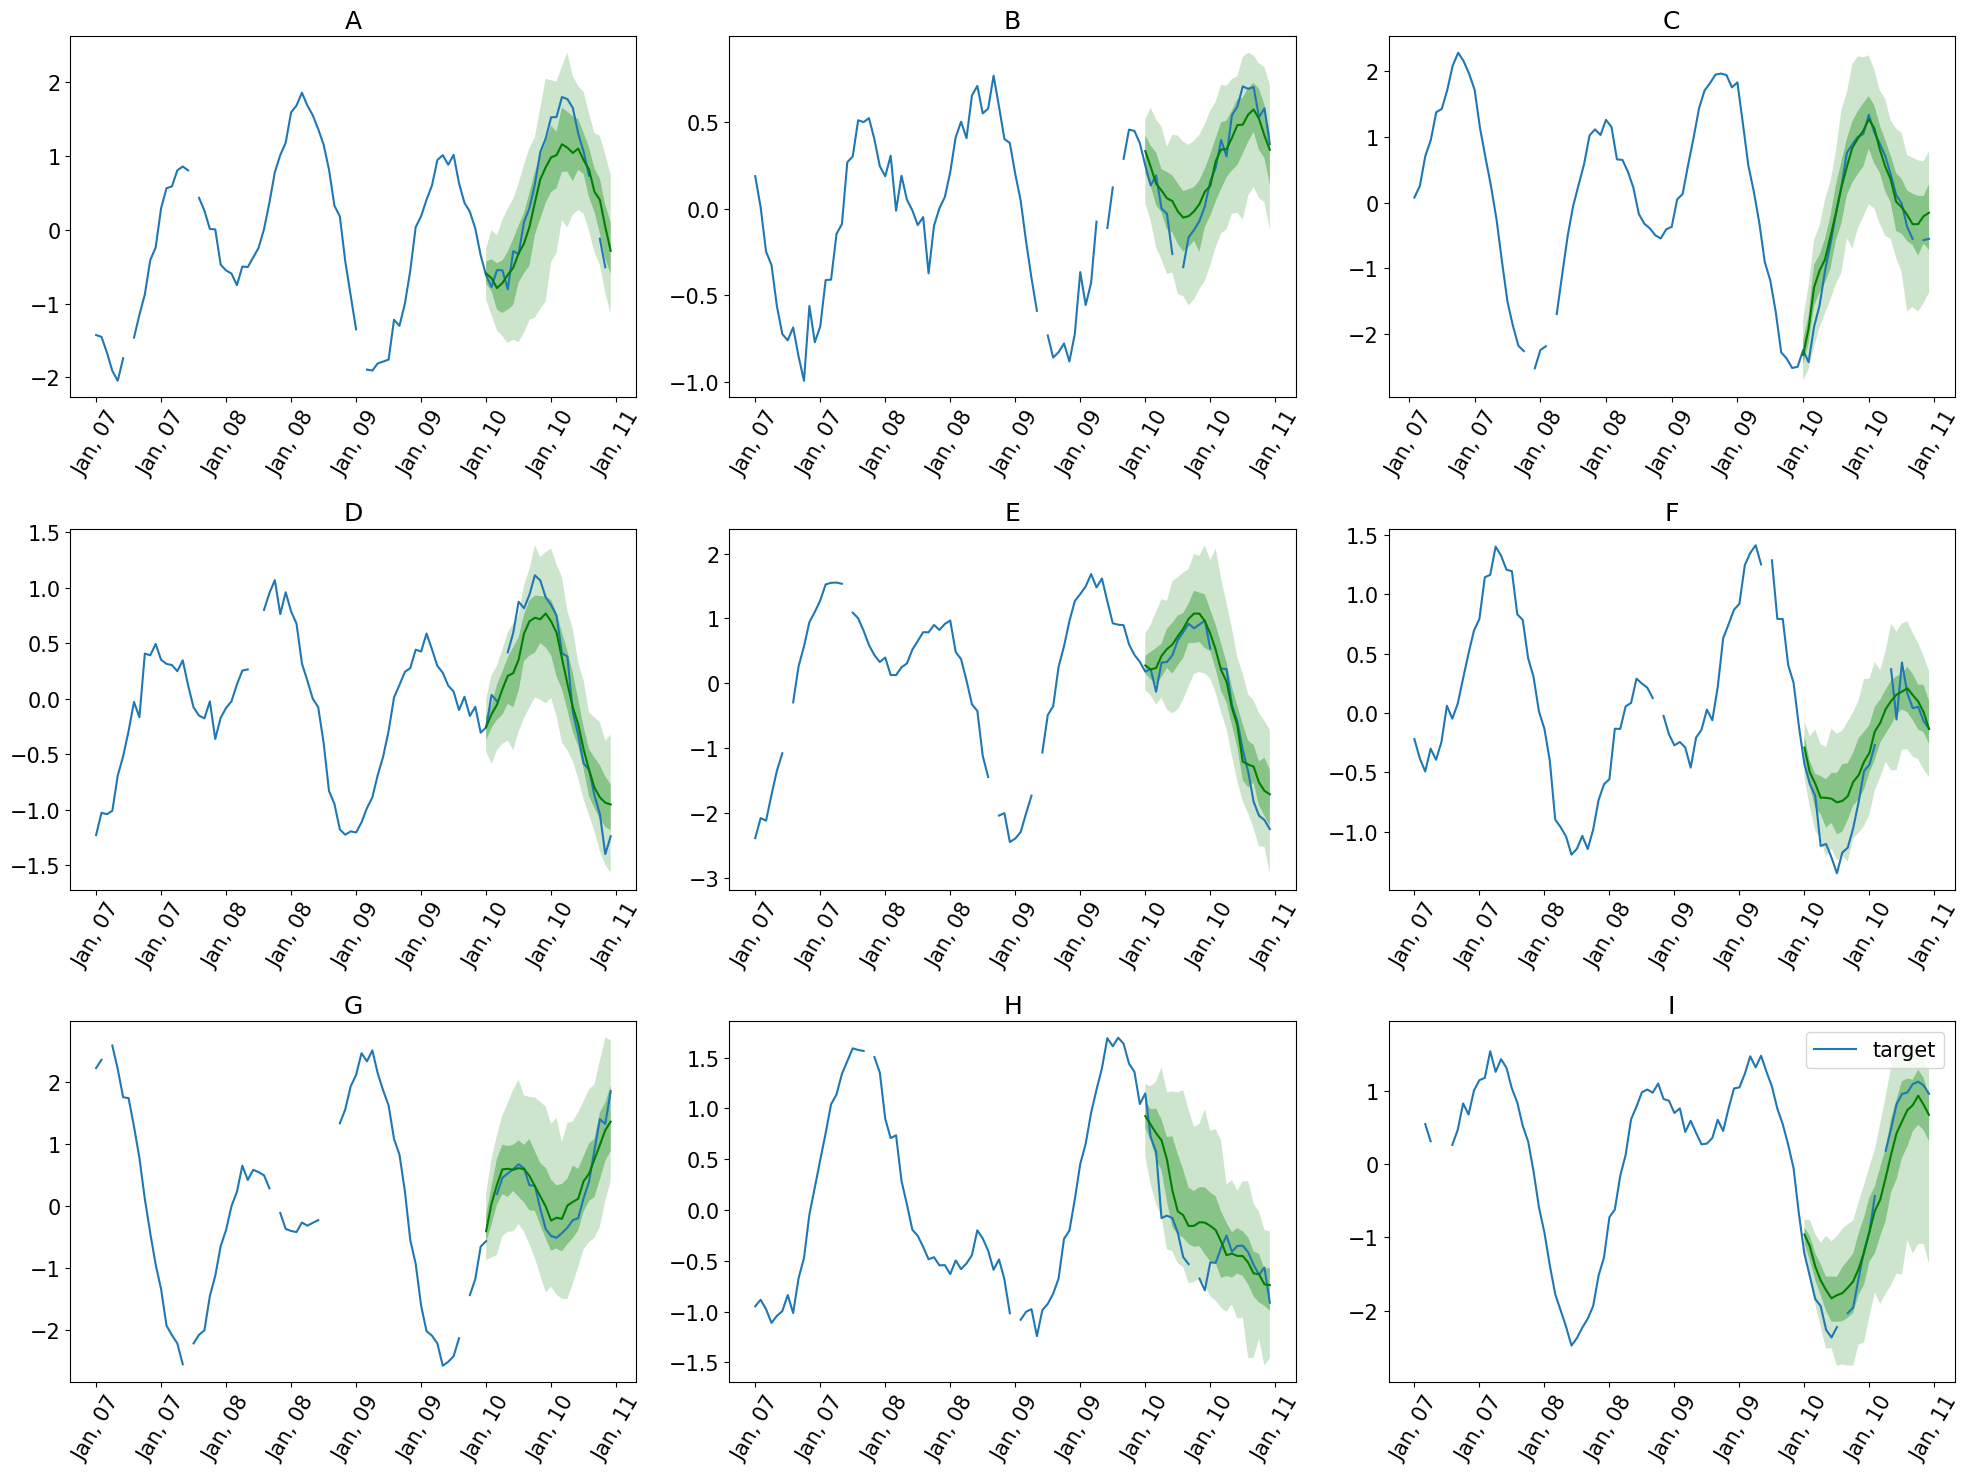

In [ ]:
plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter('%b, %d')
plt.rcParams.update({'font.size': 15})

# Iterate through the first 9 series, and plot the predicted samples
for idx, (forecast, ts) in islice(enumerate(zip(forecasts, tss)), 9):
    ax = plt.subplot(3, 3, idx+1)

    plt.plot(ts[-4 * prediction_length:].to_timestamp(), label="target", )
    forecast.plot( color='g')
    plt.xticks(rotation=60)
    ax.xaxis.set_major_formatter(date_formater)
    ax.set_title(forecast.item_id)

plt.gcf().tight_layout()
plt.legend()
plt.show()

## 3. Loading data from a wide dataframe

Here, we are given data in the `wide` format, where time series are stacked side-by-side in a `DataFrame`. We can simply turn this into a dictionary of `Series` objects with dict, and construct a `PandasDataset` with it.


### Load the dataset

In [ ]:
import pandas as pd
from gluonts.dataset.pandas import PandasDataset

url_wide = (
    "https://gist.githubusercontent.com/rsnirwan/c8c8654a98350fadd229b00167174ec4"
    "/raw/a42101c7786d4bc7695228a0f2c8cea41340e18f/ts_wide.csv"
)
df_wide = pd.read_csv(url_wide, index_col=0, parse_dates=True)
df_wide

,A,B,C,D,E,F,G,H,I,J
2021-01-01 00:00:00,-1.3378,0.1268,-0.3645,-1.0864,-2.3803,-0.2447,2.2647,-0.7917,0.7071,1.3763
2021-01-01 01:00:00,-1.6111,0.0926,-0.1364,-1.1613,-2.1421,-0.3477,2.4262,-0.9609,0.6413,1.2750
2021-01-01 02:00:00,-1.9259,-0.1420,0.1063,-1.0405,-2.1426,-0.3271,2.4434,-0.9034,0.4323,0.6767
2021-01-01 03:00:00,-1.9184,-0.4930,0.6269,-0.8531,-1.7060,-0.3088,2.4307,-0.9602,0.3193,0.5150
2021-01-01 04:00:00,-1.9168,-0.5057,0.9419,-0.7666,-1.4287,-0.4284,2.3258,-1.2504,0.3660,0.1708
...,...,...,...,...,...,...,...,...,...,...
2021-01-10 19:00:00,0.7328,0.6937,-0.3679,-0.6389,-1.3643,0.1667,0.3918,-0.4162,0.9811,1.2349
2021-01-10 20:00:00,0.4957,0.7043,-0.5553,-0.8691,-1.8283,0.0413,0.8977,-0.5412,1.0969,1.1525
2021-01-10 21:00:00,-0.1209,0.5297,-0.7084,-1.0384,-2.0439,0.0534,1.3973,-0.6366,1.1286,1.1485
2021-01-10 22:00:00,-0.5072,0.5816,-0.5735,-1.3990,-2.1105,-0.0674,1.3225,-0.5672,1.0786,1.3248


In [ ]:
# Convert numerical columns to float 32 format for lag-llama
for col in df_wide.columns:
    # Check if column is not of string type
    if df_wide[col].dtype != 'object' and pd.api.types.is_string_dtype(df_wide[col]) == False:
        df_wide[col] = df_wide[col].astype('float32')

# Create a PandasDataset
ds = PandasDataset(dict(df_wide))

backtest_dataset = ds
prediction_length = 24  # Define your prediction length (e.g., 24 here since the data frequency is hourly).
num_samples = 100 # number of samples sampled from the probability distribution for each timestep

### Get predictions

We perform zero-shot inference.

In [ ]:
forecasts, tss = get_lag_llama_predictions(backtest_dataset, prediction_length, num_samples)

`forecasts` is a list of size `num_series` where `num_series` is the number of time series in your dataset. The samples can be accessed with the `.samples` object from each forecast.

`tss` is the ground truth time series, which is useful to visualize when plotting. You can ignore it otherwise.

In [ ]:
len(forecasts)

10

In [ ]:
forecasts[0].samples.shape

(100, 24)

We plot the forecasts of our model on this dataset.

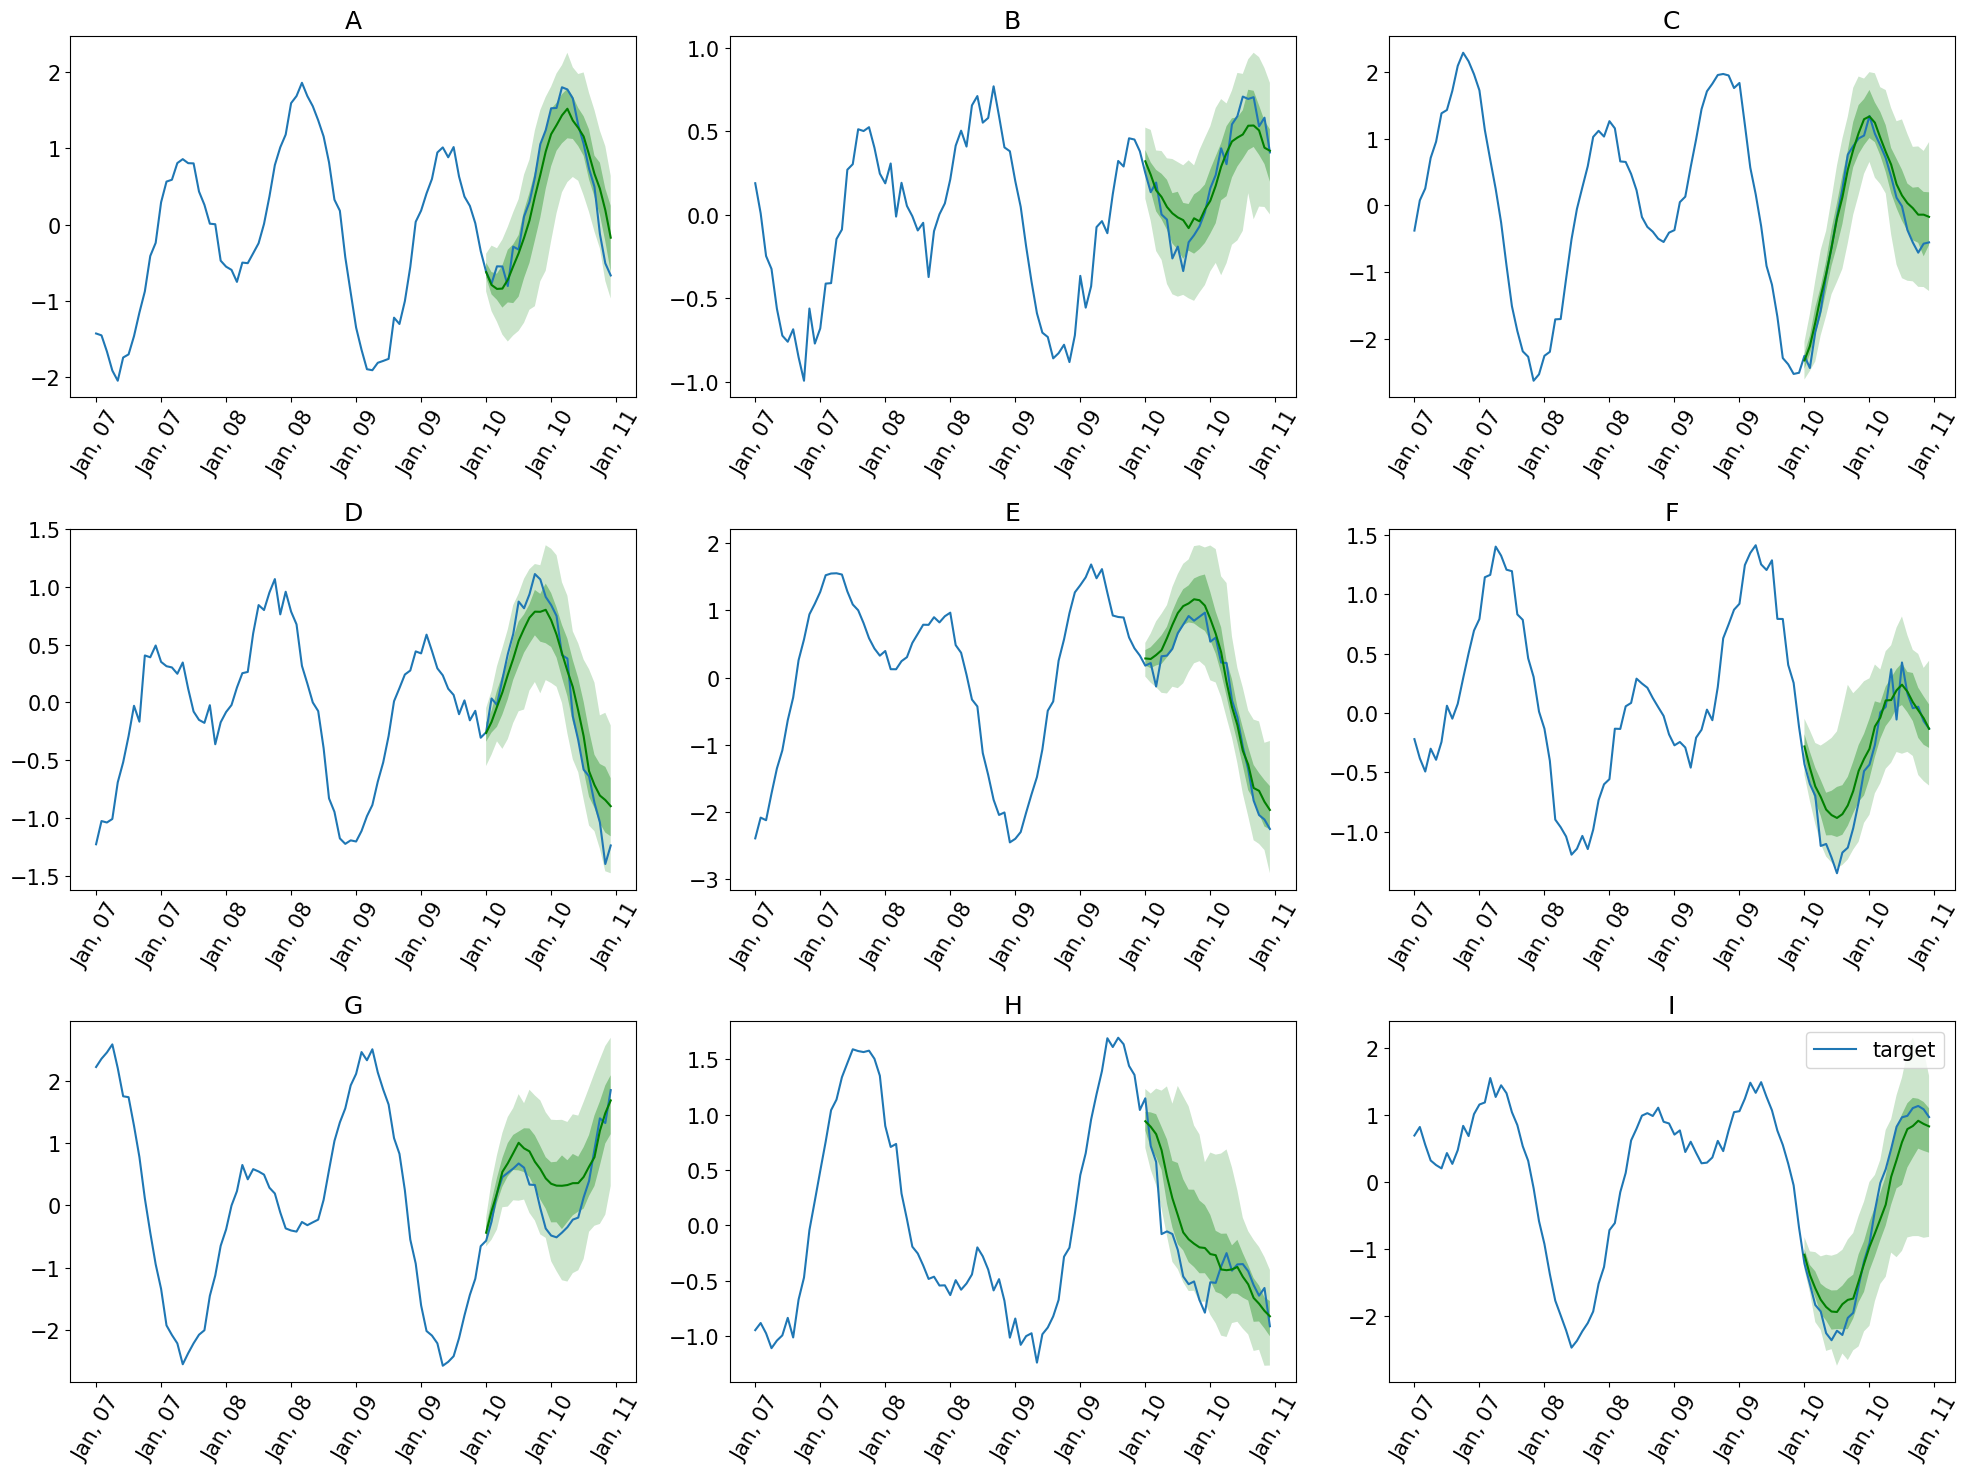

In [ ]:
plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter('%b, %d')
plt.rcParams.update({'font.size': 15})

# Iterate through the first 9 series, and plot the predicted samples
for idx, (forecast, ts) in islice(enumerate(zip(forecasts, tss)), 9):
    ax = plt.subplot(3, 3, idx+1)

    plt.plot(ts[-4 * prediction_length:].to_timestamp(), label="target", )
    forecast.plot( color='g')
    plt.xticks(rotation=60)
    ax.xaxis.set_major_formatter(date_formater)
    ax.set_title(forecast.item_id)

plt.gcf().tight_layout()
plt.legend()
plt.show()